# Data Preparation

In [14]:
from __future__ import absolute_import
from numpy import asarray, save
from mqt.predictor import utils, ml

import numpy as np
np.random.seed(10)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

predictor = ml.Predictor()

(X_train,
X_test,
y_train,
y_test,
indices_train,
indices_test,
names_list,
scores_list) = predictor.get_prepared_training_data(save_non_zero_indices=True)

scores_filtered = [scores_list[i] for i in indices_test]
names_filtered = [names_list[i] for i in indices_test]

performance = []

In [2]:
print(len(X_train), len(X_test))

2102 901


# Random Forest

/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


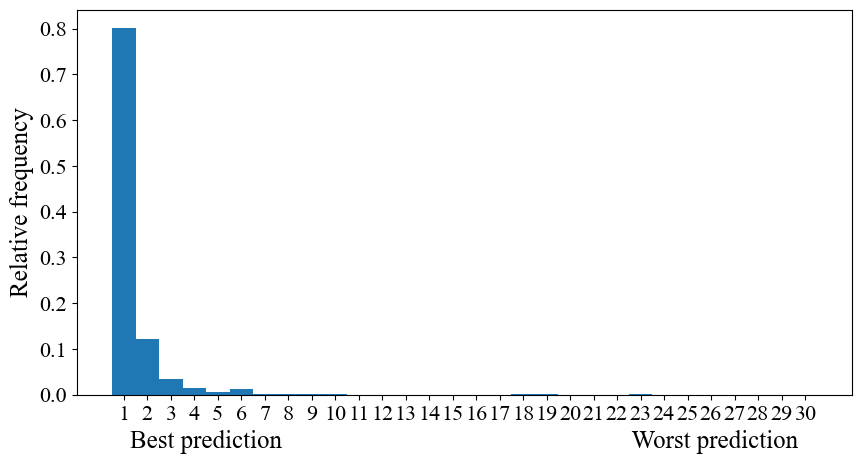

Best Accuracy:  0.7692715756136183
Top 3:  0.9556048834628191
Feature Importance:  [7.50548538e-03 9.63854169e-03 4.01932249e-03 6.79837130e-02
 3.28012318e-03 4.79981690e-05 1.51643029e-02 6.87542966e-02
 3.54111377e-04 4.04742101e-04 3.32768055e-03 2.50630278e-02
 2.26316717e-03 2.96826181e-02 2.86136932e-02 4.43348222e-03
 0.00000000e+00 1.19928581e-03 2.89509127e-02 3.31595854e-02
 0.00000000e+00 0.00000000e+00 4.74459927e-03 1.01766014e-03
 1.48128577e-01 8.36331760e-02 6.01812005e-02 8.24551667e-02
 9.93534978e-02 9.07052685e-02 9.59347645e-02]
Rel Goodness:  -0.0021
Rel Goodness Std:  0.0138


In [3]:
from sklearn.ensemble import RandomForestClassifier


clf = RandomForestClassifier(random_state=0)

tree_param = [
    {
        "n_estimators": [100, 200, 500],
        "max_depth": list(range(8, 30, 6)),
        "min_samples_split": list(range(2, 20, 6)),
        "min_samples_leaf": list(range(2, 20, 6)),
        "bootstrap": [True, False],
    },
]

clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)


y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="RandomForestClassifier")
rel_goodness = np.round(np.mean(rel_scores),4)
rel_goodness_std = np.round(np.std(rel_scores),4)
print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Random Forest", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

/Users/nils/Documents/repos/bug_mqt/ML_update2/src/mqt/predictor/ml/Predictor.py:467: RuntimeWarning: overflow encountered in double_scalars
  plt.plot(i, tmp_res[j] / max_score, "b.", alpha=1.0, markersize=1.7)


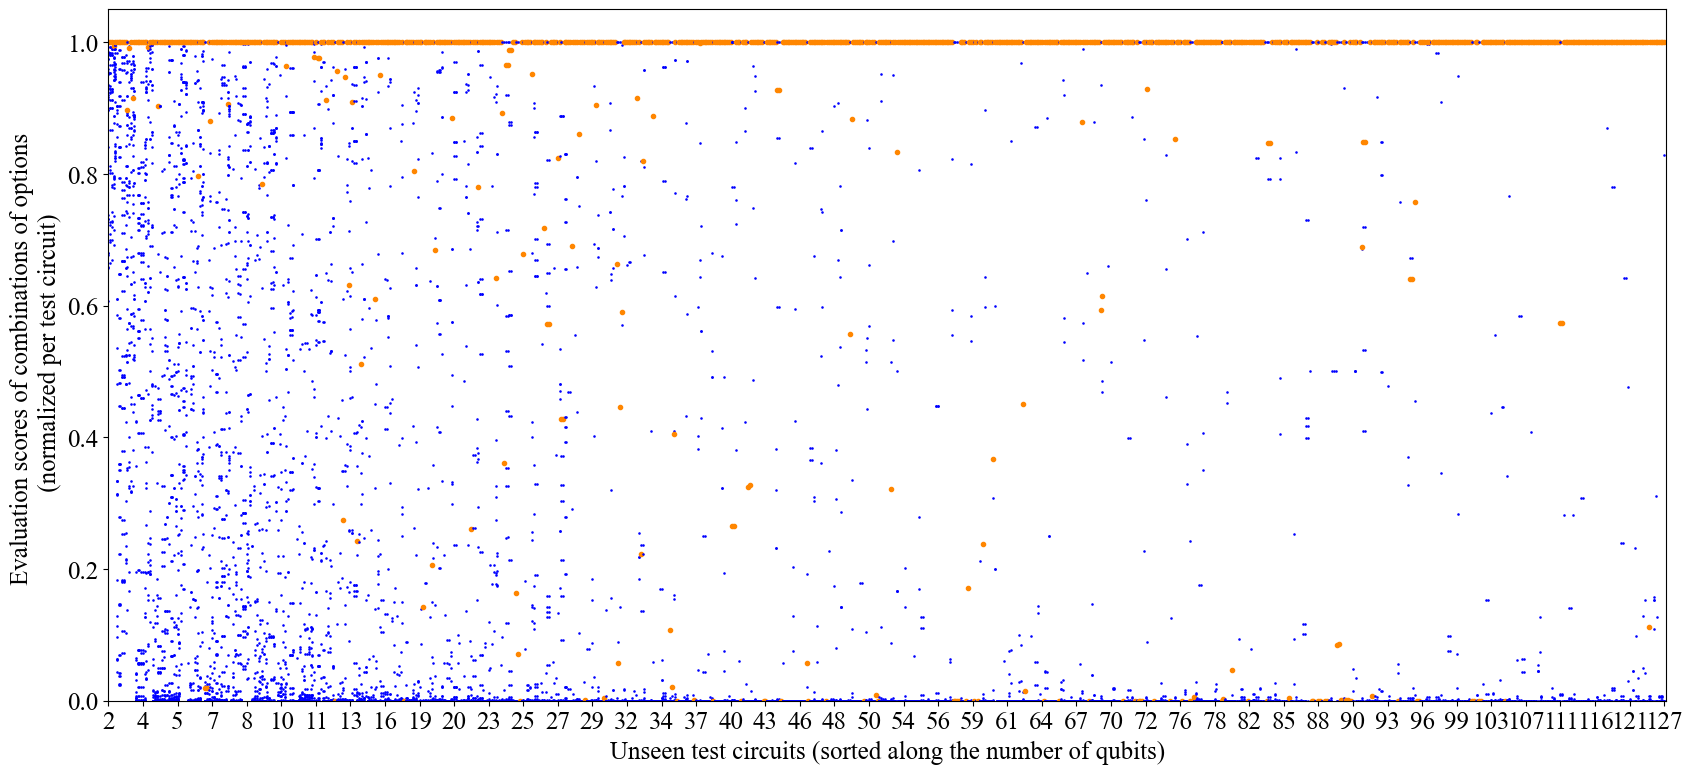

In [4]:
predictor.plot_eval_all_detailed_compact_normed(
    names_filtered, scores_filtered, y_pred, y_test
)

### Feature Importances

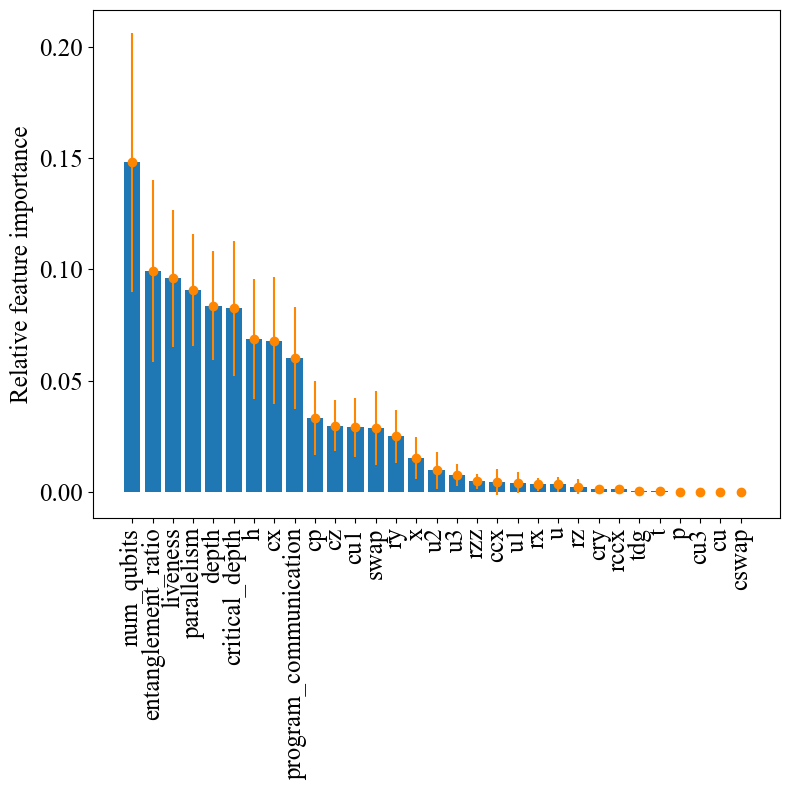

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

path = ml.helper.get_path_trained_model() / "non_zero_indices.npy"
non_zero_indices = np.load(str(path), allow_pickle=True)
        
openqasm_qc_list = ml.helper.get_openqasm_gates()
feature_names = [openqasm_qc_list[i] for i in range(0, len(openqasm_qc_list))]
feature_names.append("num_qubits")
feature_names.append("depth")
feature_names.append("program_communication")
feature_names.append("critical_depth")
feature_names.append("entanglement_ratio")
feature_names.append("parallelism")
feature_names.append("liveness")
feature_names = [feature_names[i] for i in non_zero_indices]

importances = clf.best_estimator_.feature_importances_
std = np.std(
    [tree.feature_importances_ for tree in clf.best_estimator_.estimators_], axis=0
)

idx = np.argsort(-importances)

plt.figure(figsize=(8, 8))
plt.bar(np.array(feature_names)[idx], np.array(importances)[idx])
plt.errorbar(
    np.array(feature_names)[idx],
    np.array(importances)[idx],
    np.array(std)[idx],
    fmt="o",
    color="#ff8600",
)
plt.xticks(rotation=90, fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel("Relative feature importance", fontsize=18)
plt.tight_layout()
plt.savefig("results/feature_importances.pdf")
plt.show()

#### Check the relative importances per feature

In [6]:
summary = zip(np.array(feature_names)[idx], np.array(importances)[idx])
for feature, importance in list(summary):
    print(feature, np.round(importance,3))

num_qubits 0.148
entanglement_ratio 0.099
liveness 0.096
parallelism 0.091
depth 0.084
critical_depth 0.082
h 0.069
cx 0.068
program_communication 0.06
cp 0.033
cz 0.03
cu1 0.029
swap 0.029
ry 0.025
x 0.015
u2 0.01
u3 0.008
rzz 0.005
ccx 0.004
u1 0.004
rx 0.003
u 0.003
rz 0.002
cry 0.001
rccx 0.001
tdg 0.0
t 0.0
p 0.0
cu3 0.0
cu 0.0
cswap 0.0


# GradientBoostingClassifier

/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


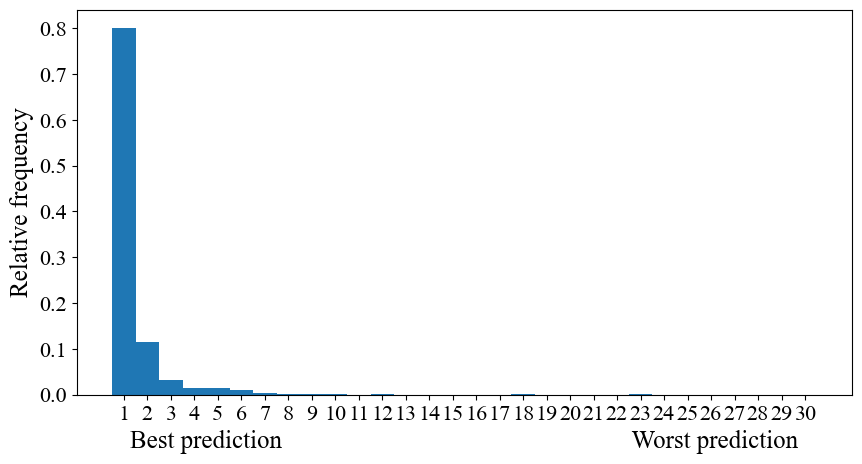

Best Accuracy:  0.7611706820495419
Top 3:  0.9456159822419534
Rel Goodness:  -0.0022
Rel Goodness Std:  0.0138


In [7]:
from sklearn.ensemble import GradientBoostingClassifier

clf = GradientBoostingClassifier()

param_grid = {
    "learning_rate": [0.01, 0.1, 1],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))

res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="GradientBoostingClassifier")
rel_goodness = np.round(np.mean(rel_scores),4)
rel_goodness_std = np.round(np.std(rel_scores),4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Gradient Boosting", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Decision Tree Classifier

/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


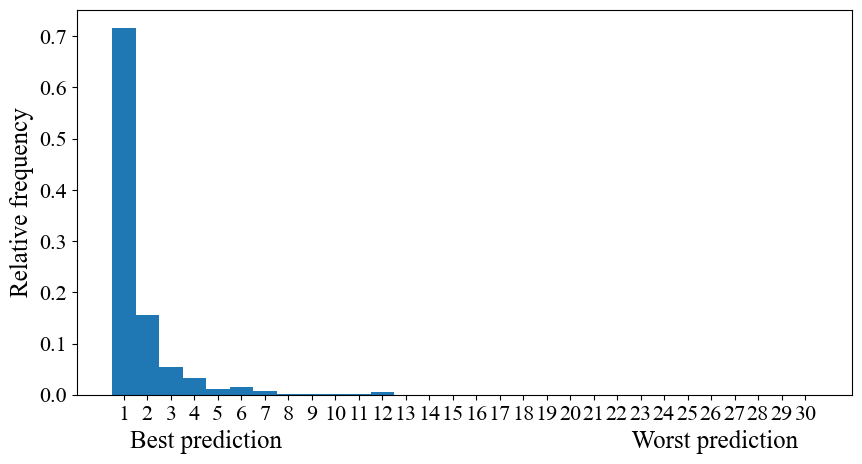

Best Accuracy:  0.7335889605248276
Top 3:  0.9245283018867925
Rel Goodness:  -0.0038
Rel Goodness Std:  0.0202
Feature Importance:  [0.         0.00125726 0.00161158 0.04433747 0.00295763 0.
 0.01350934 0.02545435 0.         0.         0.00829074 0.00995244
 0.         0.011672   0.00436576 0.         0.         0.
 0.04132516 0.00565222 0.         0.         0.00199432 0.
 0.3496802  0.09627103 0.10704398 0.05474296 0.1568422  0.01609008
 0.04694927]


In [8]:
from sklearn import tree
from sklearn.model_selection import GridSearchCV

clf = tree.DecisionTreeClassifier(random_state=5)

tree_param = [
    {
        "criterion": ["entropy", "gini"],
        "max_depth": list(range(1, 15, 1)),
        "min_samples_split": list(range(2, 20, 4)),
        "min_samples_leaf": list(range(2, 20, 4)),
        "max_leaf_nodes": list(range(2, 200, 40)),
        "max_features": list(range(1, len(non_zero_indices), 10)),
    },
]
clf = GridSearchCV(clf, tree_param, cv=5, n_jobs=8).fit(X_train, y_train)
y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="DecisionTreeClassifier")
rel_goodness = np.round(np.mean(rel_scores),4)
rel_goodness_std = np.round(np.std(rel_scores),4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
print("Feature Importance: ", clf.best_estimator_.feature_importances_)
performance.append(("Decision Tree", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Nearest Neighbor

/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


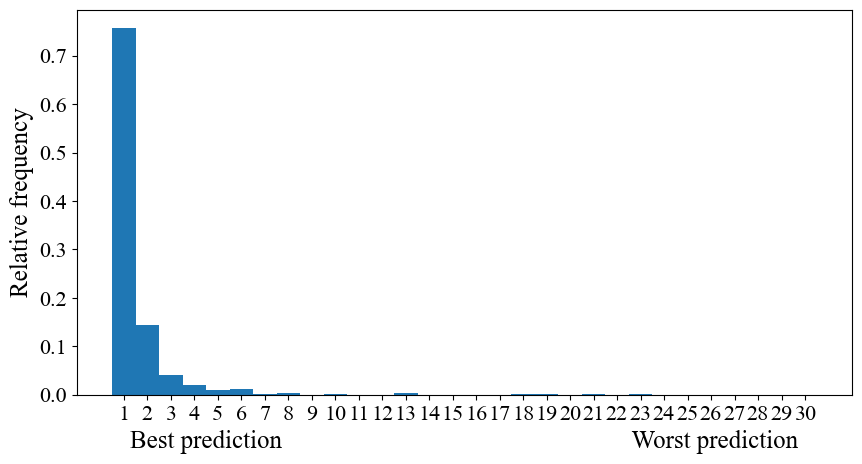

Best Accuracy:  0.7050605135165705
Top 3:  0.9400665926748057
Rel Goodness:  -0.0036
Rel Goodness Std:  0.0219


In [9]:
from sklearn.neighbors import KNeighborsClassifier

clf = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 10, 1))
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="KNeighborsClassifier")
rel_goodness = np.round(np.mean(rel_scores),4)
rel_goodness_std = np.round(np.std(rel_scores),4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Nearest Neighbor", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# MLPClassifier

/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


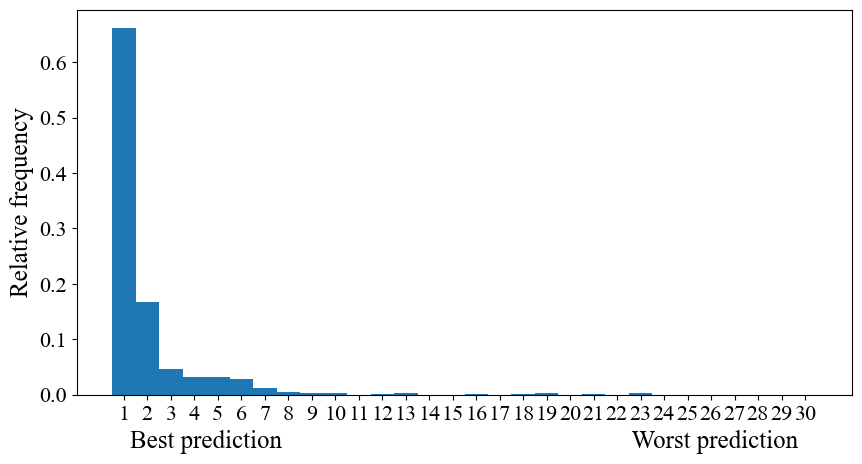

Best Accuracy:  0.6565173622893338
Top 3:  0.8745837957824639
Rel Goodness:  -0.0063
Rel Goodness Std:  0.0292


In [10]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(max_iter=1000)

param_grid = {
    "hidden_layer_sizes": [(50, 50, 50), (50, 100, 50), (100,)],
    "activation": ["tanh", "relu"],
    "solver": ["sgd", "adam"],
    "alpha": [0.0001, 0.05],
    "learning_rate": ["constant", "adaptive"],
}

clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="MLPClassifier")
rel_goodness = np.round(np.mean(rel_scores),4)
rel_goodness_std = np.round(np.std(rel_scores),4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Multilayer Perceptron", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# SVM

/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


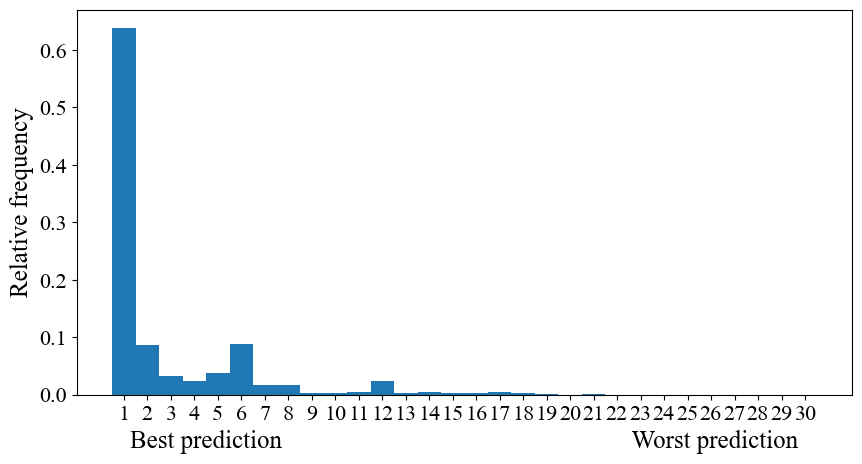

Best Accuracy:  0.620848320325755
Top 3:  0.7569367369589345
Rel Goodness:  -0.0083
Rel Goodness Std:  0.0365


In [11]:
from sklearn import svm

clf = svm.SVC()
param_grid = {"C": [0.1, 1, 10], "gamma": [1, 0.1, 0.01], "kernel": ["rbf", "sigmoid"]}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="SVM")
rel_goodness = np.round(np.mean(rel_scores),4)
rel_goodness_std = np.round(np.std(rel_scores),4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Support Vector Machine", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Naive Bayes

/Users/nils/miniforge3/lib/python3.10/site-packages/sklearn/model_selection/_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


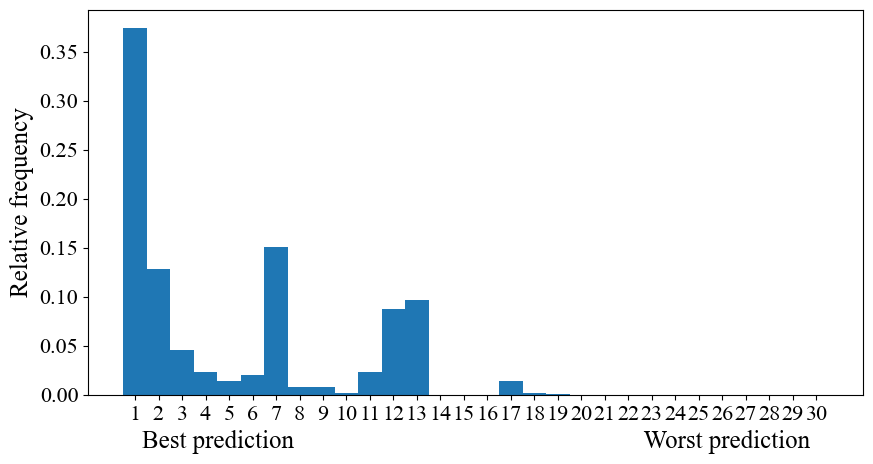

Best Accuracy:  0.3320585906571655
Top 3:  0.5482796892341842
Rel Goodness:  -0.0184
Rel Goodness Std:  0.0506


In [12]:
from sklearn.naive_bayes import GaussianNB

clf = GaussianNB()
param_grid = {"var_smoothing": np.logspace(0, -9, num=100)}
clf = GridSearchCV(clf, param_grid, cv=5, n_jobs=8).fit(X_train, y_train)

y_pred = np.array(list(clf.predict(X_test)))
res, rel_scores = predictor.calc_performance_measures(scores_filtered, y_pred, y_test)
predictor.plot_eval_histogram(res, filename="GaussianNB")
rel_goodness = np.round(np.mean(rel_scores),4)
rel_goodness_std = np.round(np.std(rel_scores),4)

print("Best Accuracy: ", clf.best_score_)
top3 = (res.count(1) + res.count(2) + res.count(3)) / len(res)
print("Top 3: ", top3)
print("Rel Goodness: ", rel_goodness)
print("Rel Goodness Std: ", rel_goodness_std)
performance.append(("Naive Bayes", clf.best_score_, top3, max(res), rel_goodness, rel_goodness_std))

# Save Performance Results

In [13]:
print(performance)

filename = "results/performances.csv"
with open(filename, "w") as f:
    f.write("Classifier, Accuracy, Top3, Worst Rank, Eval. Score Diff., Std\n")
    for sublist in performance:
        line = "{}, {}, {}, {}, {}, {} \n".format(
            sublist[0], sublist[1], sublist[2], sublist[3], sublist[4], sublist[5]
        )
        f.write(line)

[('Random Forest', 0.7692715756136183, 0.9556048834628191, 23, -0.0021, 0.0138), ('Gradient Boosting', 0.7611706820495419, 0.9456159822419534, 23, -0.0022, 0.0138), ('Decision Tree', 0.7335889605248276, 0.9245283018867925, 12, -0.0038, 0.0202), ('Nearest Neighbor', 0.7050605135165705, 0.9400665926748057, 23, -0.0036, 0.0219), ('Multilayer Perceptron', 0.6565173622893338, 0.8745837957824639, 23, -0.0063, 0.0292), ('Support Vector Machine', 0.620848320325755, 0.7569367369589345, 21, -0.0083, 0.0365), ('Naive Bayes', 0.3320585906571655, 0.5482796892341842, 19, -0.0184, 0.0506)]
